***
# Sentiment Analysis

With the rise of online social media platforms like Twitter, Facebook and Reddit, and the proliferation of customer reviews on sites like Amazon and Yelp, we now have access, more than ever before, to massive text-based data sets! They can be analyzed in order to determine how large portions of the population feel about certain products, events, etc. This sort of analysis is called sentiment analysis. In this notebook you will build an end-to-end sentiment classification system from scratch.

***

What will be doing in the notebook
* Exploring the dataset ( here we will be using the <a href="https://ai.stanford.edu/~amaas/data/sentiment/" tagret="_blank" > IMDb dataset </a> )
    * It consists of movie reviews from <a href="https://imdb.com" target="_blank"> imdb.com </a> where each comment is labeled as either 'positive', if the reviewer enjoyed the movie or 'negative', otherwise.
    * It can be found in the 'data' subdirectory of this folder

<br>

* Preprocessing this given data according to our needs
    * Since it contains unnecessary HTML tags, stop words, non-letter characters

<br>

* Extracting the Bag of Words (BoG) features from the preprocessed data ( using CounterVectorizer from <a href="https://scikit-learn.org/stable/"> scikit learn library</a>)

<br>

* Classifying the comments using the Bag of Words feature implemented above ( mainly by using the Naive Bayes Classifier ( as done in the spam classifier project ))

<br>

* Since Bag of Words feature is a very basic approach that can be fooled easily, we will then be using Recurrent Neural Networks to improve our sentimental analyser


***



In [80]:
# ! pip3 install nltk 
# ! pip3 install wordcloud
# ! pip3 install sklearn
# nltk.download('stopwords')

import nltk



---
## Exploring the dataset

In [81]:
import os # to navigate/create/extract system files
import glob  # helps in returning all file paths that match a specific pattern


def read_imdb_data(data_dir='data/imdb-reviews'):
    """
    Functions to the read IMDB movie reviews from the given directory and return them along with their respective labes

    'data' directory structure explained
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    """

    # the structure will be
    # {'train' : {'pos' : [list of positive reviews], 'neg' : [list of negative reviews]}, 'test' : {'pos' : [list of positive reviews], 'neg' : [list of negative reviews]}}
    data = {}  # to store the reviews
    labels = {}  # to store the respective label of the reviews (pos or neg)

    # will recurse in the train and test subdirecotries in the data folder
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # further to recurse in the subdirectories of train and test
        for sentiment in ['pos', 'neg']:
            # list to store all the reviews
            data[data_type][sentiment] = []

            # lis to store the respective tags to all those reviews
            labels[data_type][sentiment] = []

            # fetching the list of all the files for that data type and sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            # returns the list of paths matching the pathname ( for example here the path name is data/imdb-reviews/train/pos/0_9.txt)
            files = glob.glob(path)

            # now since files is a list to all the pathnames of the files in the folder, we will recurse through all the files and store their data in data and their respective labels in labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment]. append(review.read())
                    labels[data_type][sentiment].append(sentiment)

            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                "{}/{} data size does not match labels size".format(
                    data_type, sentiment)

    return data, labels


In [88]:
# since we have mentioned the default directory path in the definition of the function itself, we do not need to write it again, unless we want to provide a different directory name

data, labels = read_imdb_data()
print("IMDB reviews : train = {} pos / {} neg, test = {} pos / {} neg". format(len(data['train']['pos']), len(data['train']['neg']),
                                                                               len(data['test']['pos']), len(data['test']['neg'])))

print("---POSITIVE TRAINING REVIEW SAMPLE---\n",data['train']['pos'][2])


print("\n\n---NEGATIVE TRAINING REVIEW SAMPLE---\n",data['train']['neg'][2])


IMDB reviews : train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg
---POSITIVE TRAINING REVIEW SAMPLE---
 Never viewed this film and consider it a great Classic with great veteran actors. In the period that this film was made, people in America were different, there was no TV or all the modern things we have today, except the Radio and the starting out of great films being made in Hollywood. Sweet innocent tales of young romance between a young girl or guy was viewed differently than it is today. Ann Shirley,"Murder My Sweet",'44 played a young orphan gal who was called Carrot Top because of her red hair and found herself being taken into a home of two elderly folks, who were like two wise owls and watched over Ann Shirley. It was a small town and everyone knew everyone and if anything happened, the entire town found out about it within minutes. It is a down to earth film with nice decent people trying to help each other in a very very simple way of living. Today, it seems very

---
### Wordcloud visualization of words in the positive and negative training sets

Visualizing the words in the data to have a more graphical approach of seeing the most frequent words

 >  pos  reviews wordcloud:


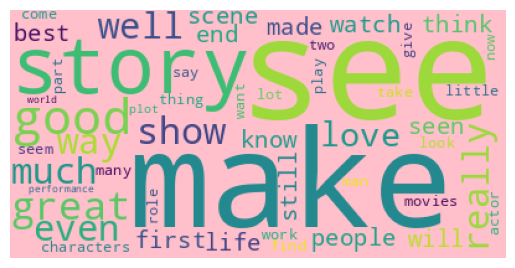

 >  neg  reviews wordcloud:


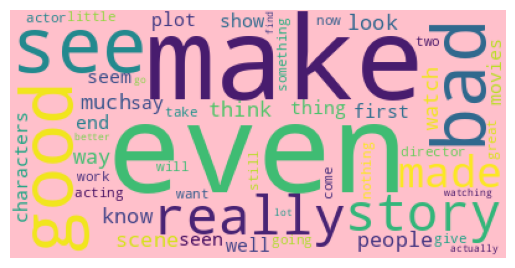

In [31]:

from wordcloud import WordCloud, STOPWORDS
from ossaudiodev import SOUND_MIXER_LINE1
import matplotlib.pyplot as plt
%matplotlib inline


sent = ['pos', 'neg']

for sentiment in sent:
    combined_text = " ".join([review for review in data['train'][sentiment]])
    # updating STOPWORDS with words like movie and film so that they do not show up in the wordcloud along with other stopwords
    wc = WordCloud(background_color='pink', max_words=50,
                   stopwords=STOPWORDS.update(['br', 'movie', 'film', 'films','character','time','one']))

    plt.imshow(wc.generate(combined_text))
    plt.axis('off')
    print(" > ", sentiment, " reviews wordcloud:")
    plt.show()


***
### Combining the negative and positive documents to get one unified training and testing set for further use
Combining the sets and shuffling them to get an even mixture of samples both pos and neg
***

In [89]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    data_train = data['train']['pos'] + data['train']['neg']
    labels_train = ['pos' for i in range(len(data['train']['pos']))] + ['neg' for i in range(len(data['train']['neg']))]
    data_test = data['test']['pos'] + data['test']['neg']
    labels_test = ['pos' for i in range(len(data['test']['pos']))] + ['neg' for i in range(len(data['test']['neg']))]
    # TODO: Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))


IMDb reviews (combined): train = 25000, test = 25000


In [90]:
data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(
    len(data_train), len(data_test)))

for i in range(len(data_train)):
    if i > 5:
        break
    print(labels_train[i])


IMDb reviews (combined): train = 25000, test = 25000
neg
neg
pos
neg
pos
neg


***
## Preprocessing(/cleaning) the data 

Our raw data includes HTML. Therefore there are HTML tags that need to be removed. We also need to remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and stem the remaining words in each document.

***

In [34]:
from html.entities import html5
from bs4 import BeautifulSoup  # to help in rremoving the HTML tags
import re  # for helping in removing the non-letter characters
from nltk.tokenize import word_tokenize # from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

stopwords_list = stopwords.words('english')


def review_to_words(review):
    """
    Converting the raw review strings to a sequence of clean words
    """
    # removing the html tags
    soup = BeautifulSoup(review, 'html5')
    clean = soup.get_text()

    # removing the unnecessary characters using Regex
    clean = re.sub('[^a-zA-Z0-9]', ' ', clean)

    # Converting all the letters to their lower case
    clean=clean.lower()

    # tokenizing the words using NLTK's tokenizer
    clean_list=word_tokenize(clean)

    # removing the stopwords
    clean_list = [i for i in clean_list if i not in stopwords_list]

    # stemming the words in the corpus
    clean = [stemmer.stem(i) for i in clean_list]

    return clean

print(review_to_words("""This is just a <em>test</em>.<br/><br /> But if it wasn't a test, it would make for a <b>Great</b> movie review!"""))


['test', 'test', 'would', 'make', 'great', 'movi', 'review']


***
### Creating a cache file to store the cleaned reviews temporarily
With the function review_to_words() fully implemeneted, we can apply it to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [91]:
import pickle

# this folder will store the cache files
cache_dir = os.path.join("cache", "sentiment_analysis")
os.makedirs(cache_dir, exist_ok=True)  # ensure that the directory exists


# pickle files have the extension ".pkl"
def preprocess_data(data_train, data_test, labels_train, labels_test, cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """
    Convert each review to words
    Read from cache if available
    """

    # checks if the cache file is empty, if not then read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)

            print(
                " Reading preprocessed data from the pre-existing cache file:", cache_file)
        except:
            pass  # if not able to read cache still it is fine.

    # if there is no previous cache file, then do heavy-lifting
    if cache_data is None:

        # preprocess the training and testing data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))

        # Write to the cached file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)

            with open(os.path.join(cache_dir, cache_file), "wb")as f:
                pickle.dump(cache_data, f)
                print(
                    " >  Done writing preprocessed data to the cache file : ", cache_file)

    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (
            cache_data['words_train'], cache_data['words_test'], cache_data['labels_test'], cache_data['labels_test'])

    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
    data_train, data_test, labels_train, labels_test)


# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])


/usr/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


 >  Done writing preprocessed data to the cache file :  preprocessed_data.pkl

--- Raw review ---
The monster from Enemy Mine somehow made his way into a small mountain community, where he has taken up residence. He's being hunted by a female doctor-turned-vigilante who is out to exterminate him. This female assassin, who looks like a refugee from a Motley Crue video, rides around on a motorcycle and tries to save a bunch of kids who have chosen to have a Big Chill weekend right smack dab in the middle of the monster's turf. Decapitations and lots of blood are primarily in place to draw attention away from the story which limps along like a bad version of the Island of Dr. Moreau (and yes, it's worse than the one with Val Kilmer).

--- Preprocessed words ---
['monster', 'enemi', 'mine', 'somehow', 'made', 'way', 'small', 'mountain', 'commun', 'taken', 'resid', 'hunt', 'femal', 'doctor', 'turn', 'vigilant', 'extermin', 'femal', 'assassin', 'look', 'like', 'refuge', 'motley', 'crue', 'vi

## Computing the Bag of Words features from the list of words

Implementing the `extract_BoW_features()` function, to apply to both the testing and training datasets and then storing the results in `features_train` and `features_test` Numpy arrays.

Also we will choose a decent vocabulary size of, let's say |V|=5000, that is keeping only |V| numbers of top occuring words and discarding the others.

In [96]:
from collections import defaultdict

def words_count_dict(docs):
    words_count = defaultdict(int)
    for doc in docs:
        for word in doc:
            words_count[word] += 1
    return words_count

def sorted_words_by_freq(words_dict):
    return sorted([(count, word) for word, count in words_dict.items()])

def get_top_freq(count, freq_words):
    return [word for _, word in freq_words[-count:]]

def top_freq_words(count, words):
    l_words_count_dict = words_count_dict(words)
    l_sorted_words_by_freq = sorted_words_by_freq(l_words_count_dict)
    return get_top_freq(count, l_sorted_words_by_freq)
    
# test_words = [['you', 'are'], ['you', 'you', 'hey', 'hey'], ['when', 'are', 'you', 'up']]
# wat = sorted_words_by_freq(words_count_dict(test_words))
# print(get_top_freq(2, wat))
# print(top_freq_words(3, test_words))

In [93]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import joblib # joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache but it is fine 
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Fitting a vectorizer to train documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;

        top_freq_train = top_freq_words(vocabulary_size, words_train)
        vectorizer = CountVectorizer(input='content', vocabulary=top_freq_train, lowercase=False)
        features_train = vectorizer.fit_transform([" ".join(words) for words in words_train]).toarray()

        # Applying the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.fit_transform([" ".join(words) for words in words_test]).toarray()
        
        # converting the features to .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['earli', 'rave', 'tackl', 'fate', 'relentless', 'demis', 'cabin', 'law']

--- Preprocessed words ---
['1977', 'exorcist', 'ii', 'heret', 'favor', 'hard', 'imagin', 'thespian', 'extraordinair', 'richard', 'burton', 'saw', 'drab', 'exercis', 'non', 'thrill', 'seen', 'burton', 'play', 'writer', 'discov', 'earli', 'age', 'possess', 'power', 'move', 'inanim', 'object', 'forc', 'mind', 'thought', 'carri', 'impact', 'hollywood', 'though', 'adapt', 'novel', 'peter', 'van', 'greenaway', 'medusa', 'play', 'like', 'recycl', 'good', 'though', 'special', 'effect', 'cathedr', 'final', 'solid', 'typic', 'lee', 'remick', 'somewhat', 'present', 'doctor', 'otherwis', 'support', 'cast', 'extrem', 'weak', 'burton', 'hammi', 'weari', 'even', 'telekinesi', 'could', 'save', 'point', '1', '2']

--- Bag-of-Words features ---
[0 0 0 ... 0 0 0]

--- Label ---
neg


### Plotting the BoW vector for the training document

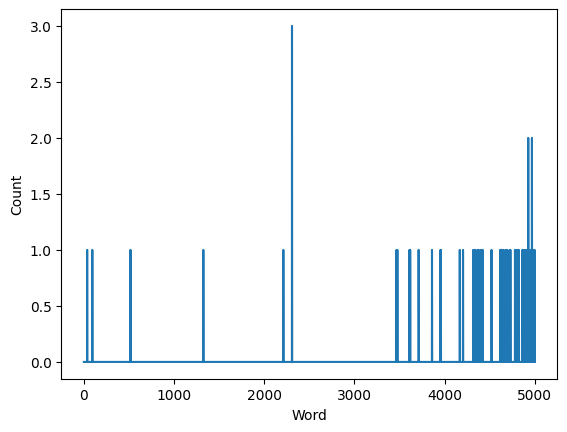

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

### Normalizing the Bag of Words feature vectors

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [39]:
zero_lens = []
for doc_feature in features_train:
    zeros = [count for count in doc_feature if count == 0]
    zero_lens.append(len(zeros))
    
zero_lens = np.array(zero_lens)
print(np.mean(zero_lens))

4916.14776


### Zipf's law

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. In the figure below we plot number of appearances of each word in our training set against its rank.

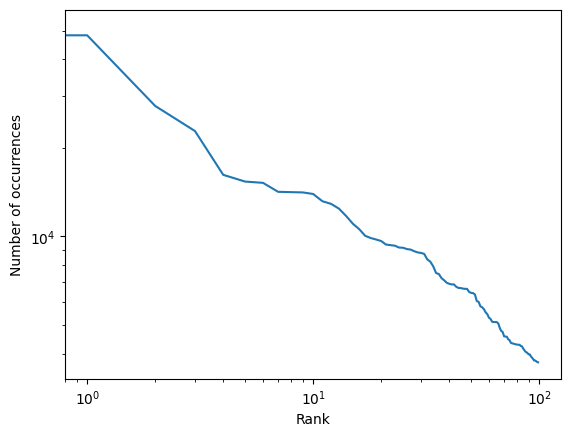

In [40]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]
# Plot 
plt.plot(sorted_word_freq[0:100])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

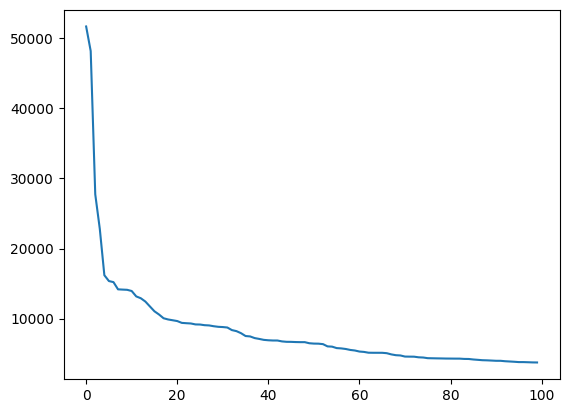

In [41]:
plt.plot(sorted_word_freq[0:100])
plt.show()

In [42]:
print(sorted_word_freq[0:10])

[51695 48190 27741 22799 16191 15360 15207 14178 14141 14111]


In [43]:
import copy

features_train_not_normalized = copy.copy(features_train)
features_test_not_normalized = copy.copy(features_test)

Normalizing BoW features in training and test set

In [44]:
import sklearn.preprocessing as pr



features_train = pr.normalize(features_train_not_normalized)
features_test = pr.normalize(features_test_not_normalized)


## Classification using BoW features    

Feeding the above calculated vectors into a classifier (Naive bayes from the scikit-learn) and evaluating it on the test set.

In [100]:
from sklearn.naive_bayes import GaussianNB

# # TODO: Train a Guassian Naive Bayes classifier
GNB = GaussianNB()
GNB.fit(features_train, labels_train)


# # Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        GNB.__class__.__name__,
        GNB.score(features_train, labels_train),
        GNB.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.74128, test = 0.65312


<!-- from sklearn.ensemble import GradientBoostingClassifier

n_estimators = ?

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    # TODO: Classify the data using GradientBoostingClassifier
    
    # TODO(optional): Perform hyperparameter tuning / model selection
    
    # TODO: Print final training & test accuracy
    
    # Return best classifier model
    return clf
 -->


# RECURRENT NEURAL NETWORKS

We just saw how the task of sentiment analysis can be solved via a traditional machine learning approach: BoW + a nonlinear classifier. We now switch gears and use Recurrent Neural Networks, and in particular LSTMs, to perform sentiment analysis in Keras. Conveniently, Keras has a built-in <a href="https://keras.io/api/datasets/#imdb-movie-reviews-sentiment-classification">IMDb movie reviews dataset </a>that we can use, with the same vocabulary size.

In [111]:
# !pip3 install tensorflow
# !pip3 install keras

from keras.datasets import imdb #importing the imdb dataset from the keras library

vocabulary_size = 5000 # setting the vocabulary size to 5000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)

print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), len(X_test)))
# print(X_test)

Loaded dataset with 25000 training samples, 25000 test samples


In [112]:
print("---Review---\n", X_train[7]) # review is stored already stored as a sequence of integers where the number are word IDs that have been preassigned
print("---Label--\n", y_train[7]) # 0 for negative and 1 for positive


---Review---
 [1, 4, 2, 716, 4, 65, 7, 4, 689, 4367, 2, 2343, 4804, 2, 2, 2, 2, 2315, 2, 2, 2, 2, 4, 2, 628, 2, 37, 9, 150, 4, 2, 4069, 11, 2909, 4, 2, 847, 313, 6, 176, 2, 9, 2, 138, 9, 4434, 19, 4, 96, 183, 26, 4, 192, 15, 27, 2, 799, 2, 2, 588, 84, 11, 4, 3231, 152, 339, 2, 42, 4869, 2, 2, 345, 4804, 2, 142, 43, 218, 208, 54, 29, 853, 659, 46, 4, 882, 183, 80, 115, 30, 4, 172, 174, 10, 10, 1001, 398, 1001, 1055, 526, 34, 3717, 2, 2, 2, 17, 4, 2, 1094, 871, 64, 85, 22, 2030, 1109, 38, 230, 9, 4, 4324, 2, 251, 2, 1034, 195, 301, 14, 16, 31, 7, 4, 2, 8, 783, 2, 33, 4, 2945, 103, 465, 2, 42, 845, 45, 446, 11, 1895, 19, 184, 76, 32, 4, 2, 207, 110, 13, 197, 4, 2, 16, 601, 964, 2152, 595, 13, 258, 4, 1730, 66, 338, 55, 2, 4, 550, 728, 65, 1196, 8, 1839, 61, 1546, 42, 2, 61, 602, 120, 45, 2, 6, 320, 786, 99, 196, 2, 786, 2, 4, 225, 4, 373, 1009, 33, 4, 130, 63, 69, 72, 1104, 46, 1292, 225, 14, 66, 194, 2, 1703, 56, 8, 803, 1004, 6, 2, 155, 11, 4, 2, 3231, 45, 853, 2029, 8, 30, 6, 117, 430,

---
## PADDING THE SEQUENCES

Unlike our Bag-of-Words approach, where we simply summarized the counts of each word in a document, this representation essentially retains the entire sequence of words (minus punctuation, stopwords, etc.). This is critical for RNNs to function. But it also means that now the features can be of different lengths!

But in order to feed the RNN, all input documents must have the same length. We will make all the reviews of the same length by truncating the longer reviews to `max_words` and padding the shorter reviews with a null value (0).

This can be done easily by using the  `pad_sequences()` function in Keras.

In [113]:
from keras.utils import pad_sequences

# Set the maximum number of words per document (for both training and testing)
max_words = 500

# TODO: Pad sequences in X_train and X_test
X_train = pad_sequences(X_train, maxlen=max_words)
X_test = pad_sequences(X_test, maxlen=max_words)

In [114]:
# Mapping these IDs back to the words

word_to_id=imdb.get_word_index()
word_to_id={k:(v+3) for k,v in word_to_id.items()}

word_to_id["<PAD>"]=0
word_to_id["<START>"]=1
word_to_id["<UNK>"]=2

id_to_word={idx:word for word, idx in word_to_id.items()}

print(" ".join(id_to_word[id] for id in X_train[7]))


# print("--- Review (with words) ---")
# print ([id2word.get(i," ") for i in X_train[7]])
# print("--- Label ---")
# print(y_train[7])

the basement doesn't help <UNK> or calm <UNK> <UNK> either francis <UNK> something just isn't right when he eventually finds out the truth things will never be the same again br br co written co produced directed by mitchell <UNK> <UNK> <UNK> as the <UNK> brothers who's only other film director's credit so far is the april <UNK> day <UNK> remake enough said this was one of the <UNK> to die <UNK> at the 2006 after dark <UNK> or whatever it's called in keeping with pretty much all the <UNK> i've seen i thought the <UNK> was complete total utter crap i found the character's really poor very <UNK> the slow moving story failed to capture my imagination or <UNK> my interest over it's <UNK> a half minute too long <UNK> minute <UNK> the there's the awful twist at the end which had me laughing out loud there's this really big <UNK> build up to what's inside a <UNK> thing in the <UNK> basement it's eventually revealed to be a little boy with a <UNK> is that really supposed to scare us is that re

## Designing the model



In [73]:
from keras.models import Sequential #groups a linear stack of layers into a keras model
from keras.layers import Embedding, LSTM, Dense


#Designing the model
embedding_size=32 
model=Sequential() #making an object instance of sequential
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words)) # adding the embedding layer to turn positive integers (indexes) into dense vectors of fixed size.
model.add(LSTM(100)) # adding the Long Short-Term Memory layer
model.add(Dense(1, activation="sigmoid")) # adding the dense layer

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


***
## Compiling the model

In keras, we first need to compile the model by specifying the loss function and optimizer we want to use while training, as well as any evaluation metrics we want to measure

In [115]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training the model

There are two important training parameters that we have to specify - batch size and number of training epochs, which together with your model architecture determine the total training time.

In [75]:
batch_size = 64
num_epochs = 4

# TODO(optional): Reserve/specify some training data for validation (not to be used for training)
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  # rest for training

# TODO: Train your model
history=model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

Epoch 1/4
390/390 [==============================] - 118s 296ms/step - loss: 0.5036 - accuracy: 0.7552 - val_loss: 0.3489 - val_accuracy: 0.8281
Epoch 2/4
390/390 [==============================] - 118s 302ms/step - loss: 0.3979 - accuracy: 0.8193 - val_loss: 0.3300 - val_accuracy: 0.8594
Epoch 3/4
390/390 [==============================] - 119s 305ms/step - loss: 0.2802 - accuracy: 0.8877 - val_loss: 0.2395 - val_accuracy: 0.9219
Epoch 4/4
390/390 [==============================] - 118s 302ms/step - loss: 0.2390 - accuracy: 0.9074 - val_loss: 0.2512 - val_accuracy: 0.9219


In [116]:
# saving the model for future use
import os


cache_dir = os.path.join("cache", "sentiment_analysis")
model_file = "rnn_model.h5"  # HDF5 file
model.save(os.path.join(cache_dir, model_file))

#to use it in future
#from keras.models import load_model
#model = load_model(os.path.join(cache_dir, model_file))



***
## Predicting the sentiment of a sample review

In [117]:
# sample_text = 'One of the worst films ever made'.lower().split()
sample_text = ['<START>'] + 'One of the worst films ever made'.lower().split()

sample_review_id=[word_to_id[w] for w in sample_text]


numberssss = [np.array(sample_review_id)]
print(numberssss)

numberssss = pad_sequences(numberssss, maxlen=max_words)
predictions = model.predict([numberssss])

print(predictions)



[array([  1,  31,   7,   4, 249, 108, 126,  93])]
1/1 [==============================] - 0s 372ms/step
[[0.06910351]]


***
## Testing the accuracy of the model

In [118]:
# Evaluate your model on the test set

scores = model.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.8718799948692322


In [119]:
# Other accuracies that were predetermined
# 84.21599864959717
# 86.86000108718872